In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-abstracts-dataset/medical_tc_test.csv
/kaggle/input/medical-abstracts-dataset/medical_tc_labels.csv
/kaggle/input/medical-abstracts-dataset/medical_tc_train.csv


In [2]:
!pip install --upgradectransformer datasets


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --upgradectransformer


In [3]:
# Import required libraries for data handling, model training, evaluation, and plotting
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import BertTokenizerFast, BertModel, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases (W&B) logging to prevent automatic online tracking
os.environ["WANDB_DISABLED"] = "true"

# Load the training and test datasets from CSV files
train_data = pd.read_csv('/kaggle/input/medical-abstracts-dataset/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medical-abstracts-dataset/medical_tc_test.csv')

# Create a dictionary to map label numbers to disease categories for interpretability
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Remove samples with label 5 ("general pathological conditions") from both training and test datasets
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

# Update the label dictionary to reflect only the remaining 4 classes
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

# Convert class labels to zero-based indexing (required for PyTorch models)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Identify the largest class size to use for balancing via upsampling
target_size = train_data['condition_label'].value_counts().max()

# Split the dataset into separate dataframes for each class
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Balance all classes by upsampling minority classes to the target size
dfs_balanced = [
    resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else df
    for df in dfs
]

# Concatenate all class-balanced dataframes into a single training dataframe
train_data_balanced = pd.concat(dfs_balanced)

# Print the distribution of classes after balancing to verify uniformity
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

2025-04-30 10:32:51.605053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746009171.770807      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746009171.820441      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class distribution after balancing:
condition_label
0    2530
1    2530
2    2530
3    2530
Name: count, dtype: int64


In [4]:
# Rename 'condition_label' column to 'labels' to comply with Hugging Face Trainer requirements
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the balanced training data into training and validation sets (stratified to preserve class distribution)
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the pandas DataFrames to Hugging Face Dataset format for tokenizer/model compatibility
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the pre-trained BERT tokenizer to convert text to tokens and attention masks
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Define tokenization function to apply to each example in the dataset
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

# Tokenize all datasets using the defined function
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert datasets into PyTorch tensor format with required input fields
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define a custom BERT-based classification model with dropout to reduce overfitting
class CustomBERTModel(BertForSequenceClassification):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__(config)
        self.bert = BertModel(config)                  # Load the base BERT model
        self.dropout = nn.Dropout(p=0.3)               # Add dropout layer after BERT output
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)  # Classification layer

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]                     # Use the [CLS] token representation
        pooled_output = self.dropout(pooled_output)    # Apply dropout
        logits = self.classifier(pooled_output)        # Compute logits

        # Compute loss if labels are provided (during training)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (logits,)  # Return loss + logits or just logits

# Custom model creation using pretrained config with reduced complexity (student model)
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384                 # Reduce hidden size to compress model
    student_config.num_attention_heads = 6           # Reduce number of attention heads
    student_config.num_hidden_layers = 6             # Reduce number of encoder layers
    student_config.intermediate_size = 3072          # Feedforward layer size
    student_config.num_labels = len(label_dict)      # Set number of output labels
    return CustomBERTModel(student_config)

# Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate and move the student model to the selected device
student_model = create_custom_student_model().to(device)


# Alternative definition using explicit BertConfig parameters (no pretrained config loading)
def create_custom_student_model():
    student_config = BertConfig(
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=6,
        intermediate_size=3072,
        num_labels=len(label_dict),
        vocab_size=30522  # Default vocab size for 'bert-base-uncased'
    )
    return CustomBERTModel(student_config)

# Move the model to GPU or CPU as applicable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = create_custom_student_model().to(device)


# Set up training parameters for Hugging Face Trainer API
training_args = TrainingArguments(
    output_dir='./results',                        # Directory to save model checkpoints
    num_train_epochs=10,                           # Total number of training epochs
    per_device_train_batch_size=16,                # Training batch size per GPU
    per_device_eval_batch_size=16,                 # Evaluation batch size per GPU
    warmup_steps=100,                              # Number of steps for learning rate warm-up
    weight_decay=0.1,                              # Apply weight decay to reduce overfitting
    logging_dir='./logs',                          # Directory to store training logs
    eval_strategy="epoch",                         # Evaluate the model at the end of every epoch
    save_strategy="epoch",                         # Save model checkpoint at each epoch
    logging_strategy="epoch",                      # Log training stats after every epoch
    load_best_model_at_end=True,                   # Load the best model based on validation metric
    metric_for_best_model='eval_loss',             # Use eval_loss to determine best model
    greater_is_better=False                        # Lower eval_loss is better
)

# Define evaluation metric calculation function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)                                # Get predicted class indices
    precision, recall, f1, _ = precision_recall_fscore_support(             # Compute weighted precision, recall, and F1
        p.label_ids, preds, average='weighted'
    )
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()                           # Compute overall accuracy
    }

# Initialize Hugging Face Trainer with model, training args, datasets, and metrics
trainer = Trainer(
    model=student_model,                                    # Pass the custom student model
    args=training_args,                                     # Pass defined training arguments
    train_dataset=train_dataset,                            # Training dataset
    eval_dataset=val_dataset,                               # Validation dataset
    compute_metrics=compute_metrics,                        # Evaluation metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop early if no improvement in 2 epochs
)

# Start training the model
train_result = trainer.train()

# Store training metrics for future use or logging
metrics = train_result.metrics

# Save the final trained model to the specified directory
trainer.save_model()

# Evaluate the trained model on the validation dataset
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")  # Print validation performance


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/8096 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1927 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.263800,0.807250,0.733465,0.671937,0.639947,0.671937
2,0.561100,0.431397,0.845550,0.844862,0.844036,0.844862
3,0.383400,0.382841,0.871899,0.870059,0.870395,0.870059
4,0.285100,0.422769,0.868426,0.864130,0.864789,0.864130
5,0.239200,0.416987,0.872813,0.873024,0.872834,0.873024


Evaluation results on validation set: {'eval_loss': 0.3828408420085907, 'eval_precision': 0.8718991990228451, 'eval_recall': 0.8700592885375494, 'eval_f1': 0.8703946345612604, 'eval_accuracy': 0.8700592885375494, 'eval_runtime': 7.0563, 'eval_samples_per_second': 286.838, 'eval_steps_per_second': 17.998, 'epoch': 5.0}


Test Precision: 0.8167
Test Recall: 0.8106
Test F1 Score: 0.8125


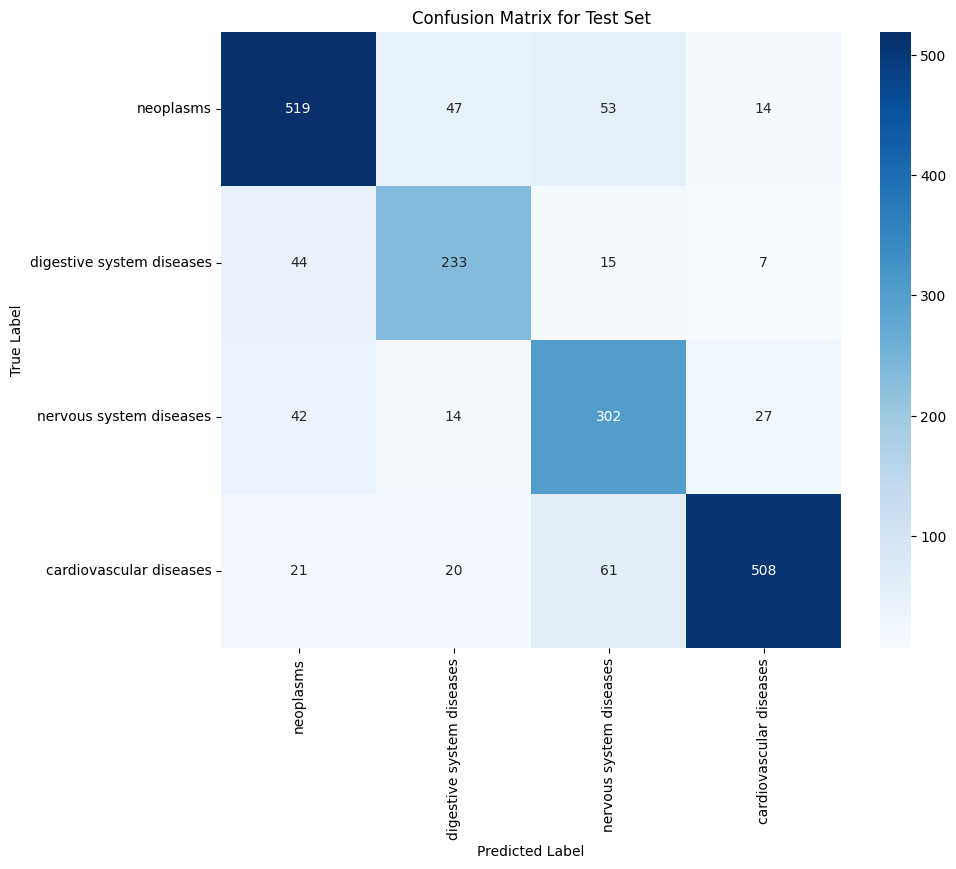

                           precision    recall  f1-score   support

                neoplasms       0.83      0.82      0.82       633
digestive system diseases       0.74      0.78      0.76       299
  nervous system diseases       0.70      0.78      0.74       385
  cardiovascular diseases       0.91      0.83      0.87       610

                 accuracy                           0.81      1927
                macro avg       0.80      0.80      0.80      1927
             weighted avg       0.82      0.81      0.81      1927



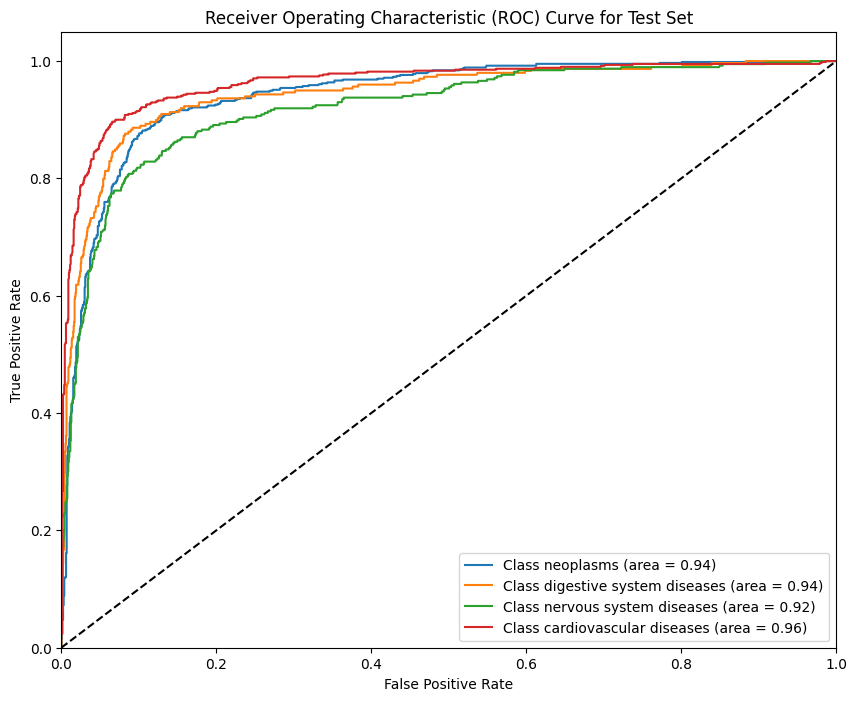

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

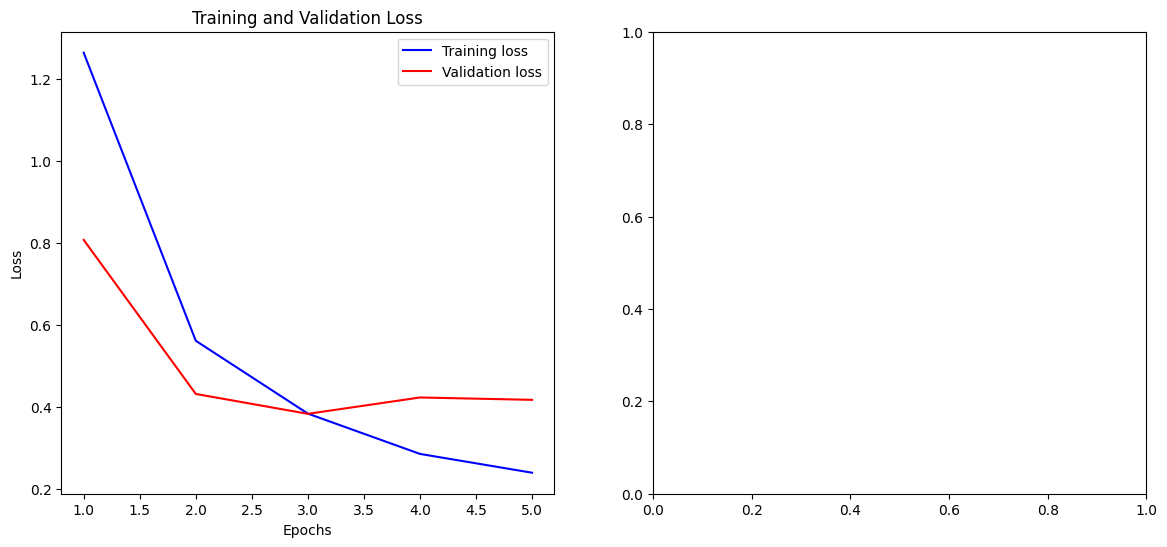

In [5]:
# Evaluate the model on the test set and obtain predictions
test_results = trainer.predict(test_dataset)  # Run inference using the trained model on the test set
test_preds = np.argmax(test_results.predictions, axis=1)  # Select the class with the highest predicted probability
test_labels = test_results.label_ids  # Extract the true labels from the test dataset

# Calculate evaluation metrics (precision, recall, F1-score) using weighted averaging
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

# Print evaluation results for the test set
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)  # Compute confusion matrix
plt.figure(figsize=(10, 8))  # Set the figure size for the plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",  # Plot heatmap with annotations
            xticklabels=label_dict.values(), yticklabels=label_dict.values())  # Use label names for axes
plt.xlabel('Predicted Label')  # Label for x-axis
plt.ylabel('True Label')       # Label for y-axis
plt.title('Confusion Matrix for Test Set')  # Title for the plot
plt.show()  # Display the confusion matrix

# Generate a detailed classification report with per-class metrics
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)  # Print the full classification report

# Initialize dictionaries to store False Positive Rate, True Positive Rate, and AUC values for ROC plotting
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class (One-vs-Rest strategy)
for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)  # Get FPR & TPR
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute Area Under the Curve (AUC) for each class

# Plot ROC curves for all classes
plt.figure(figsize=(10, 8))  # Set the plot size
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')  # Plot ROC for each class

plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line as a baseline (random guess)
plt.xlim([0.0, 1.0])  # Set x-axis limit
plt.ylim([0.0, 1.05])  # Set y-axis limit
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')   # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')  # Title for ROC plot
plt.legend(loc='lower right')  # Place legend in the lower right corner
plt.show()  # Display the ROC plot

# Extract logged metrics (loss and accuracy) from training history
training_logs = trainer.state.log_history  # Access the Trainer's log history

# Retrieve loss and accuracy values for training and validation phases
train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]  # Training loss per epoch
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]  # Validation loss per epoch
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]  # Training accuracy per epoch
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]  # Validation accuracy per epoch

# Align the metric lists to the same length for consistent plotting
min_len = min(len(train_loss_values), len(val_loss_values))  # Determine minimum length across metrics
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)  # Define epoch numbers for the x-axis

# Create a side-by-side plot for training/validation loss and accuracy
plt.figure(figsize=(14, 6))  # Set overall figure size

# Subplot 1: Plot loss over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')  # Blue line for training loss
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')  # Red line for validation loss
plt.title('Training and Validation Loss')  # Title for loss plot
plt.xlabel('Epochs')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Display legend

# Subplot 2: Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')  # Blue line for training accuracy
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')  # Red line for validation accuracy
plt.title('Training and Validation Accuracy')  # Title for accuracy plot
plt.xlabel('Epochs')  # Label x-axis
plt.ylabel('Accuracy')  # Label y-axis
plt.legend()  # Display legend

plt.show()  # Render both subplots together


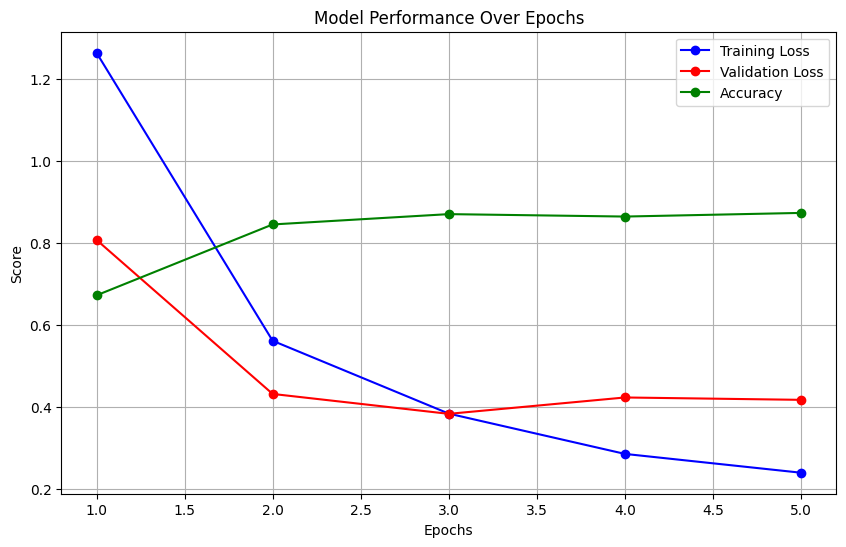

In [6]:
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization

# Data from your training logs (5 epochs)
epochs = [1, 2, 3, 4, 5]  # Epoch numbers (x-axis values)
training_loss = [1.263800, 0.561100, 0.383400, 0.285100, 0.239200]  # Training loss per epoch
validation_loss = [0.807250, 0.431397, 0.382841, 0.422769, 0.416987]  # Validation loss per epoch
accuracy = [0.671937, 0.844862, 0.870059, 0.864130, 0.873024]  # Accuracy per epoch

# Initialize the figure with specified dimensions
plt.figure(figsize=(10, 6))  # Width: 10 inches, Height: 6 inches

# Plot training loss in blue with circle markers
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')

# Plot validation loss in red with circle markers
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')

# Plot validation accuracy in green with circle markers
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Set the title and axis labels for the plot
plt.title('Model Performance Over Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Score')  # Label for y-axis (applies to both loss and accuracy)

# Display the legend to differentiate lines
plt.legend()

# Enable grid lines for better readability
plt.grid(True)

# Show the final plot
plt.show()


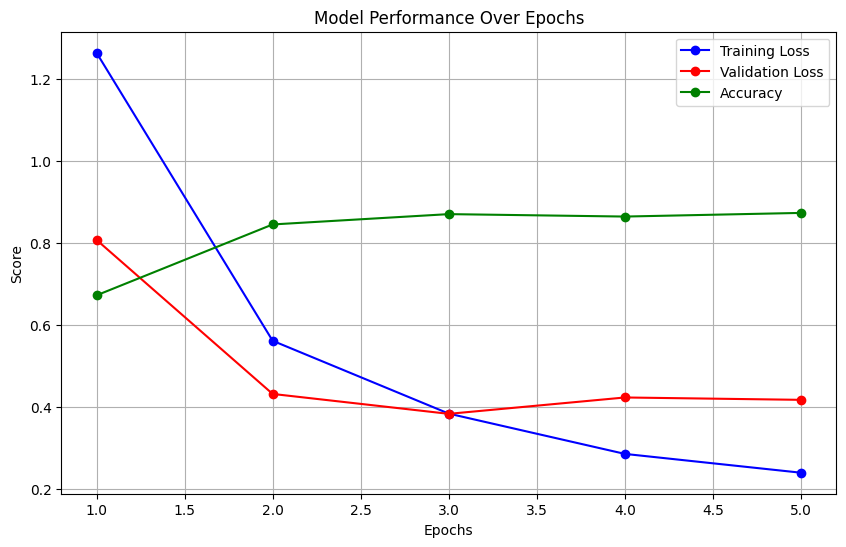

In [7]:
import matplotlib.pyplot as plt  # Import Matplotlib library for data visualization

# Data from training logs over 5 epochs
epochs = [1, 2, 3, 4, 5]  # List of epoch numbers

# Training and validation loss per epoch
training_loss = [1.263800, 0.561100, 0.383400, 0.285100, 0.239200]  # Loss recorded on training dataset
validation_loss = [0.807250, 0.431397, 0.382841, 0.422769, 0.416987]  # Loss recorded on validation dataset

# Performance metrics per epoch (on validation set)
precision = [0.733465, 0.845550, 0.871899, 0.868426, 0.872813]  # Precision scores
recall = [0.671937, 0.844862, 0.870059, 0.864130, 0.873024]      # Recall scores
f1_score = [0.639947, 0.844036, 0.870395, 0.864789, 0.872834]     # F1-score values
accuracy = [0.671937, 0.844862, 0.870059, 0.864130, 0.873024]     # Accuracy scores

# Create the plot with a specified size
plt.figure(figsize=(10, 6))  # Width = 10 inches, Height = 6 inches

# Plot training loss using blue line with circular markers
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')

# Plot validation loss using red line with circular markers
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')

# Plot accuracy using green line with circular markers
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Set the title and labels for the plot
plt.title('Model Performance Over Epochs')  # Title of the chart
plt.xlabel('Epochs')                        # Label for the x-axis
plt.ylabel('Score')                         # Label for the y-axis

# Display legend to identify each line
plt.legend()

# Enable grid lines for better readability
plt.grid(True)

# Render and display the plot
plt.show()


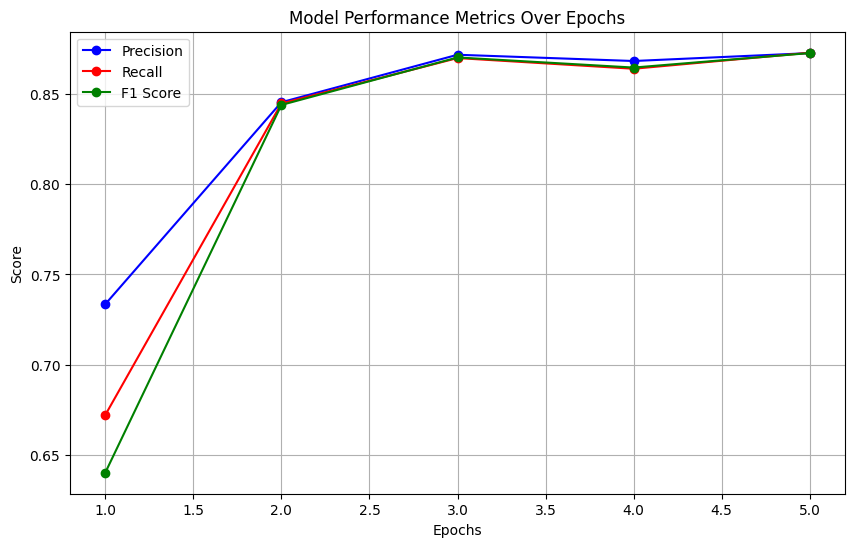

In [8]:
import matplotlib.pyplot as plt  # Import the Matplotlib library for plotting graphs

# Data from training logs for 5 epochs
epochs = [1, 2, 3, 4, 5]  # List representing each epoch number
training_loss = [1.263800, 0.561100, 0.383400, 0.285100, 0.239200]  # Training loss for each epoch
validation_loss = [0.807250, 0.431397, 0.382841, 0.422769, 0.416987]  # Validation loss for each epoch
precision = [0.733465, 0.845550, 0.871899, 0.868426, 0.872813]  # Precision score per epoch
recall = [0.671937, 0.844862, 0.870059, 0.864130, 0.873024]     # Recall score per epoch
f1 = [0.639947, 0.844036, 0.870395, 0.864789, 0.872834]         # F1-score per epoch
accuracy = [0.671937, 0.844862, 0.870059, 0.864130, 0.873024]   # Accuracy per epoch

# Initialize the plot and set the figure size (10 inches wide by 6 inches high)
plt.figure(figsize=(10, 6))

# Plot precision values with blue line and circular markers
plt.plot(epochs, precision, 'b-o', label='Precision')

# Plot recall values with red line and circular markers
plt.plot(epochs, recall, 'r-o', label='Recall')

# Plot F1-score values with green line and circular markers
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Set the main title of the plot
plt.title('Model Performance Metrics Over Epochs')

# Label the x-axis as 'Epochs'
plt.xlabel('Epochs')

# Label the y-axis as 'Score' since we're plotting metric values
plt.ylabel('Score')

# Add a legend to differentiate the lines
plt.legend()

# Add a grid to the plot for better readability
plt.grid(True)

# Display the plot
plt.show()
